<a href="https://colab.research.google.com/github/QuantumNews/Grovers-search-algorithm-and-QAE/blob/main2/QAE_for_dummies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install qiskit


     |████████████████████████████████| 6.5 MB 7.7 MB/s 
     |████████████████████████████████| 18.0 MB 63 kB/s 
     |████████████████████████████████| 238 kB 45.6 MB/s 
     |████████████████████████████████| 200 kB 47.7 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 1.6 MB 30.9 MB/s 
     |████████████████████████████████| 943 kB 52.0 MB/s 
     |████████████████████████████████| 38.2 MB 1.1 MB/s 
     |████████████████████████████████| 49 kB 6.8 MB/s 
     |████████████████████████████████| 38.1 MB 1.2 MB/s 
     |████████████████████████████████| 49 kB 7.0 MB/s 
     |████████████████████████████████| 3.6 MB 40.4 MB/s 
     |████████████████████████████████| 113 kB 66.2 MB/s 
  Created wheel for qiskit: filename=qiskit-0.34.2-py3-none-any.whl size=11805 sha256=3c11eb5bdd5c1ee8c1ec502214e88b73d4d08bd230e50c297d581108e98024b6
  Stored in directory: /root/.cache/pip/wheels/62/77/65/cda6eedfdd2a525bd3f479a4386930ae3088a1eb01f8c94

In [ ]:

p = 0.2

import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k


ModuleNotFoundError: ignored

In [ ]:
A = BernoulliA(p)
Q = BernoulliQ(p)

In [ ]:
from qiskit.algorithms import EstimationProblem

problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

In [ ]:
from qiskit import BasicAer
from qiskit.utils import QuantumInstance

backend = BasicAer.get_backend("statevector_simulator")
quantum_instance = QuantumInstance(backend)

In [ ]:
from qiskit.algorithms import AmplitudeEstimation

ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    quantum_instance=quantum_instance,
)

In [ ]:
ae_result = ae.estimate(problem)

In [ ]:
print(ae_result.estimation)

0.1464466


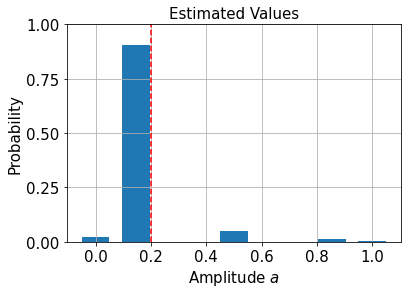

In [ ]:
import matplotlib.pyplot as plt

# plot estimated values
gridpoints = list(ae_result.samples.keys())
probabilities = list(ae_result.samples.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()

In [ ]:
print("Interpolated MLE estimator:", ae_result.mle)

Interpolated MLE estimator: 0.19999999390907777


In [ ]:
!pip install pylatexenc


     |████████████████████████████████| 162 kB 5.1 MB/s 
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136835 sha256=8f7df50b0b66deed632fc3bf8750318e1c56a0a44a45a63b425a8814f877bb5a
  Stored in directory: /root/.cache/pip/wheels/f1/8a/f5/33ee79d4473eb201b519fa40f989b842e373237395a3421f52
Successfully built pylatexenc


In [ ]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.draw()  # decompose 1 level: exposes the Phase estimation circuit!

┌──────┐
eval_0: ──────────────┤0     ├
                      │      │
eval_1: ──────────────┤1     ├
                      │  QPE │
eval_2: ──────────────┤2     ├
        ┌────────────┐│      │
     q: ┤ Ry(0.9273) ├┤3     ├
        └────────────┘└──────┘

In [ ]:
from qiskit import transpile


basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2).draw()

┌───┐     ┌──────┐                                               »
eval_0: ────┤ H ├─────┤ P(0) ├──■────────────────────────────────────────────»
            ├───┤     ├──────┤  │                                            »
eval_1: ────┤ H ├─────┤ P(0) ├──┼────────────────────────────────────────────»
            ├───┤     ├──────┤  │                                            »
eval_2: ────┤ H ├─────┤ P(0) ├──┼────────────────────────────────────────────»
        ┌───┴───┴────┐└──────┘┌─┴─┐┌─────┐┌───┐┌─────┐┌─────────────────────┐»
     q: ┤ Ry(0.9273) ├────────┤ X ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(2.21429743558818) ├»
        └────────────┘        └───┘└─────┘└───┘└─────┘└─────────────────────┘»
«                                                                    »
«eval_0: ──────────────────────────────■─────────────────────────────»
«                                      │                             »
«eval_1: ──────────────────────────────┼─────────────────────────────»
«                                      │                             »
«eval_2: ──────────────────────────────┼─────────────────────────────»
«        ┌─────┐┌───┐┌─────┐┌───────┐┌─┴─┐┌──────┐┌─────┐┌───┐┌─────┐»
«     q: ┤ Sdg ├┤ H ├┤ Sdg ├┤ P(3π) ├┤ X ├┤ P(0) ├┤ Sdg ├┤ H ├┤ Sdg ├»
«        └─────┘└───┘└─────┘└───────┘└───┘└──────┘└─────┘└───┘└─────┘»
«                                                                            »
«eval_0: ────────────────────────────────────────────────────────────────────»
«                                                                            »
«eval_1: ─────────────────────────────────────────────────────■──────────────»
«                                                             │              »
«eval_2: ─────────────────────────────────────────────────────┼──────────────»
«        ┌─────────────────────┐┌─────┐┌───┐┌─────┐┌───────┐┌─┴─┐┌─────┐┌───┐»
«     q: ┤ P(4.06888787159141) ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(3π) ├┤ X ├┤ Sdg ├┤ H ├»
«        └─────────────────────┘└─────┘└───┘└─────┘└───────┘└───┘└─────┘└───┘»
«                                                                       »
«eval_0: ───────────────────────────────────────────────────────────────»
«                                                                       »
«eval_1: ────────────────────────────────────────────────────────────■──»
«                                                                    │  »
«eval_2: ────────────────────────────────────────────────────────────┼──»
«        ┌─────┐┌─────────────────────┐┌─────┐┌───┐┌─────┐┌───────┐┌─┴─┐»
«     q: ┤ Sdg ├┤ P(1.28700221758657) ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(3π) ├┤ X ├»
«        └─────┘└─────────────────────┘└─────┘└───┘└─────┘└───────┘└───┘»
«                                                                             »
«eval_0: ─────────────────────────────────────────────────────────────────────»
«                                                                             »
«eval_1: ─────────────────────────────────────────────────────────────────────»
«                                                                             »
«eval_2: ─────────────────────────────────────────────────────────────────────»
«        ┌──────┐┌─────┐┌───┐┌─────┐┌─────────────────────┐┌─────┐┌───┐┌─────┐»
«     q: ┤ P(0) ├┤ Sdg ├┤ H ├┤ Sdg ├┤ P(4.99618308959302) ├┤ Sdg ├┤ H ├┤ Sdg ├»
«        └──────┘└─────┘└───┘└─────┘└─────────────────────┘└─────┘└───┘└─────┘»
«                                                                              »
«eval_0: ──────────────────────────────────────────────────────────────────────»
«                                                                              »
«eval_1: ──────────────────────────────────────────────────────────────────────»
«                                                                              »
«eval_2: ───────────■──────────────────────────────────────────────────────────»
«        ┌───────┐┌─┴─┐┌─────┐┌───┐┌─────┐┌───────────────────────┐┌─────┐┌───┐